# gluonts12-end_dates (quarterly, deepar)

This notebook is used to check the performance of `deepar` on the quarterly subsets of the m4 data with the same end dates. 

In [1]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import gluonts
print(gluonts.__version__)

import mxnet
print(mxnet.__version__)

# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar

0.4.2
1.4.1


INFO:root:Using CPU


In [4]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_end2003q3', 'm4_quarterly_end2013q1', 'm4_quarterly_end2015q1', 'm4_quarterly_finance', 'm4_quarterly_id

## Check datasets

In [5]:
dataname = "m4_weekly"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:downloading and processing m4_weekly


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/test/data.json


**To do:** Transfer the quarterly datasets to the right place: 

- `mv [data] ../../.mxnet/gluon-ts/datasets

In [7]:
dataname1 = "m4_quarterly_end2003q3"
dataset1 = utils.get_dataset(dataname1, regenerate=False)
len(dataset1.train) # 728

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2003q3.


728

In [8]:
dataname2 = "m4_quarterly_end2013q1"
dataset2 = utils.get_dataset(dataname2, regenerate=False)
len(dataset2.train) # 1119

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2013q1.


1119

In [9]:
dataname3 = "m4_quarterly_end2015q1"
dataset3 = utils.get_dataset(dataname3, regenerate=False)
len(dataset3.train) # 4126

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2015q1.


4126

In [10]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length of the series
print("length train dataset", len(dataset.train))
print("length test dataset", len(dataset.train))


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train dataset 359
length test dataset 359


In [11]:
train_entry

{'start': Timestamp('1750-01-04 00:00:00', freq='W-SUN'),
 'target': array([ 1089.2 ,  1078.91,  1079.88, ..., 36565.18, 36565.18, 35397.16],
       dtype=float32),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json'), line=1), row=1)}

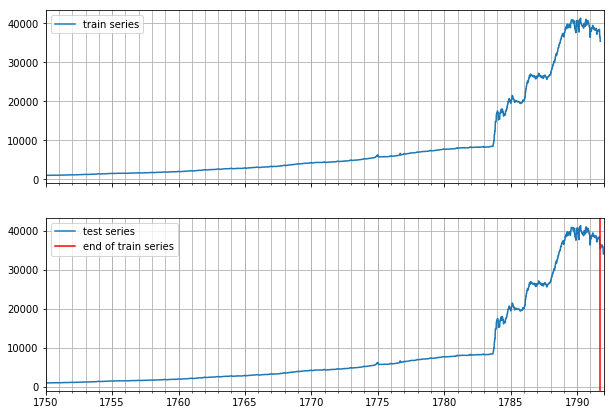

In [12]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [13]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [14]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df

## Results

## Study 1: `m4_quarterly_end2003q3`

In [16]:
dataname1

'm4_quarterly_end2003q3'

In [ ]:
results = pd.DataFrame()

for i in range(45, 47):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_end2003q3", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2003q3.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 66923


Seed: 45


100%|██████████| 200/200 [00:05<00:00, 34.15it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[0] Elapsed time 5.858 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.204479
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.04it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[1] Elapsed time 5.260 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.392577
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 37.72it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[2] Elapsed time 5.307 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.144669
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 35.40it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[3] Elapsed time 5.654 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=5.978732
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.36it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[4] Elapsed time 5.225 seconds
INFO:root:Epo

100%|██████████| 200/200 [00:05<00:00, 34.50it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[37] Elapsed time 5.801 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.303865
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 33.21it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[38] Elapsed time 6.034 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.304522
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.23it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[39] Elapsed time 5.237 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.314296
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.16it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[40] Elapsed time 5.247 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.313108
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 35.98it/s, avg_epoch_loss=5.28]
INFO:root:Epoch[41] Elapsed time 5.565 seconds


100%|██████████| 200/200 [00:06<00:00, 32.69it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[74] Elapsed time 6.120 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.151617
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 36.77it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[75] Elapsed time 5.445 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.150110
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 33.81it/s, avg_epoch_loss=5.19]
INFO:root:Epoch[76] Elapsed time 5.918 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.192166
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 32.73it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[77] Elapsed time 6.114 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.147060
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 33.92it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[78] Elapsed time 5.902 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 38.77it/s, avg_epoch_loss=5.05]
INFO:root:Epoch[111] Elapsed time 5.162 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.050048
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 39.20it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[112] Elapsed time 5.104 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.055864
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 38.49it/s, avg_epoch_loss=5.04]
INFO:root:Epoch[113] Elapsed time 5.199 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.044876
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 39.71it/s, avg_epoch_loss=5.05]
INFO:root:Epoch[114] Elapsed time 5.038 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.051020
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 43.17it/s, avg_e

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 43.19it/s, avg_epoch_loss=5]
INFO:root:Epoch[147] Elapsed time 4.635 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=4.996051
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 41.43it/s, avg_epoch_loss=4.96]
INFO:root:Epoch[148] Elapsed time 4.830 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=4.958615
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 42.67it/s, avg_epoch_loss=4.96]
INFO:root:Epoch[149] Elapsed time 4.692 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=4.960335
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 200/200 [00:05<00:00, 38.72it/s, avg_epoch_loss=4.98]
INFO:root:Epoch[150] Elapsed time 5.168 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=4.979083
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 42.15it/s

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.45it/s, avg_epoch_loss=4.96]
INFO:root:Epoch[183] Elapsed time 5.204 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=4.958313
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.38it/s, avg_epoch_loss=4.93]
INFO:root:Epoch[184] Elapsed time 5.082 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=4.928655
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.64it/s, avg_epoch_loss=4.94]
INFO:root:Epoch[185] Elapsed time 5.184 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=4.942371
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.26it/s, avg_epoch_loss=4.95]
INFO:root:Epoch[186] Elapsed time 4.975 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=4.953635
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.78it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=4.951724
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.10it/s, avg_epoch_loss=4.93]
INFO:root:Epoch[220] Elapsed time 4.642 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=4.930090
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.22it/s, avg_epoch_loss=4.94]
INFO:root:Epoch[221] Elapsed time 4.741 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=4.944856
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.38it/s, avg_epoch_loss=4.91]
INFO:root:Epoch[222] Elapsed time 4.509 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=4.912192
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.22it/s, avg_epoch_loss=4.92]
INFO:root:Epoch[223] Elapsed time 4.976 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=4.921074
INFO:root:Epoch[224] Learning rate is 5e-05

100%|██████████| 200/200 [00:05<00:00, 39.27it/s, avg_epoch_loss=4.95]
INFO:root:Epoch[256] Elapsed time 5.096 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=4.951824
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.50it/s, avg_epoch_loss=4.94]
INFO:root:Epoch[257] Elapsed time 4.827 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=4.939981
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.02it/s, avg_epoch_loss=4.93]
INFO:root:Epoch[258] Elapsed time 4.999 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=4.927247
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.87it/s, avg_epoch_loss=4.91]
INFO:root:Epoch[259] Elapsed time 5.030 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=4.912597
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.73it/s, avg_epoch_loss=4.92]
INFO:root:Epoch[260] Elapsed time

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.89it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[293] Elapsed time 5.740 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=4.879787
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.11it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[294] Elapsed time 5.866 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=4.899471
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.61it/s, avg_epoch_loss=4.92]
INFO:root:Epoch[295] Elapsed time 5.784 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=4.919292
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 35.55it/s, avg_epoch_loss=4.91]
INFO:root:Epoch[296] Elapsed time 5.632 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=4.913236
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.52it/s, avg_epoch_l

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=4.899609
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.83it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[330] Elapsed time 5.749 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=4.900942
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.09it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[331] Elapsed time 5.256 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=4.892203
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.23it/s, avg_epoch_loss=4.91]
INFO:root:Epoch[332] Elapsed time 6.211 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=4.906346
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.73it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[333] Elapsed time 5.453 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=4.892255
INFO:root:Epoch[334] Learning rate is 5e-05


100%|██████████| 200/200 [00:05<00:00, 35.30it/s, avg_epoch_loss=4.87]
INFO:root:Epoch[366] Elapsed time 5.670 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=4.869875
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.55it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[367] Elapsed time 6.148 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=4.887918
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.61it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[368] Elapsed time 4.943 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=4.895593
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.18it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[369] Elapsed time 5.243 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=4.890460
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.22it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[370] Elapsed time 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.114356  0.044072  19.477263            0.047236            0.030391   

   seed  epochs  num_batches  
0    45     400          200  
Seed: 46


100%|██████████| 200/200 [00:05<00:00, 39.61it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[0] Elapsed time 5.053 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.041343
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 41.91it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[1] Elapsed time 4.774 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.523103
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.61it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[2] Elapsed time 4.926 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.211719
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.94it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[3] Elapsed time 5.009 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.070256
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 41.28it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[4] Elapsed time 4.849 seconds
INFO:root:E

100%|██████████| 200/200 [00:04<00:00, 40.81it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[37] Elapsed time 4.904 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.286780
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 41.93it/s, avg_epoch_loss=5.26]
INFO:root:Epoch[38] Elapsed time 4.777 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.261416
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 41.47it/s, avg_epoch_loss=5.26]
INFO:root:Epoch[39] Elapsed time 4.825 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.258705
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.35it/s, avg_epoch_loss=5.25]
INFO:root:Epoch[40] Elapsed time 4.959 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.250768
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.04it/s, avg_epoch_loss=5.28]
INFO:root:Epoch[41] Elapsed time 5.125 second

100%|██████████| 200/200 [00:04<00:00, 40.63it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[74] Elapsed time 4.926 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.113463
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.65it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[75] Elapsed time 4.925 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.111788
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 37.12it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[76] Elapsed time 5.393 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.115919
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.37it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[77] Elapsed time 5.086 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.092366
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 41.82it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[78] Elapsed time 4.792 second

100%|██████████| 200/200 [00:06<00:00, 33.29it/s, avg_epoch_loss=5.03]
INFO:root:Epoch[111] Elapsed time 6.011 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.026994
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 32.91it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[112] Elapsed time 6.083 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.063054
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 34.06it/s, avg_epoch_loss=5.02]
INFO:root:Epoch[113] Elapsed time 5.874 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.024827
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.91it/s, avg_epoch_loss=5.05]
INFO:root:Epoch[114] Elapsed time 5.147 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.053077
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 41.57it/s, avg_epoch_loss=5.02]
INFO:root:Epoch[115] Elapsed time

100%|██████████| 200/200 [00:05<00:00, 35.19it/s, avg_epoch_loss=4.97]
INFO:root:Epoch[149] Elapsed time 5.689 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=4.966671
INFO:root:Epoch[150] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 33.98it/s, avg_epoch_loss=4.94]
INFO:root:Epoch[150] Elapsed time 5.897 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=4.940185
INFO:root:Epoch[151] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 33.70it/s, avg_epoch_loss=4.94]
INFO:root:Epoch[151] Elapsed time 5.938 seconds
INFO:root:Epoch[151] Evaluation metric 'epoch_loss'=4.937492
INFO:root:Epoch[152] Learning rate is 0.0005
100%|██████████| 200/200 [00:06<00:00, 32.55it/s, avg_epoch_loss=4.93]
INFO:root:Epoch[152] Elapsed time 6.151 seconds
INFO:root:Epoch[152] Evaluation metric 'epoch_loss'=4.930389
INFO:root:Epoch[153] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 34.78it/s, avg_epoch_loss=4.94]
INFO:root:Epoch[153] Elapsed 

INFO:root:Epoch[185] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 42.28it/s, avg_epoch_loss=4.85]
INFO:root:Epoch[185] Elapsed time 4.733 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=4.854479
INFO:root:Loading parameters from best epoch (175)
INFO:root:Epoch[186] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 41.46it/s, avg_epoch_loss=4.85]
INFO:root:Epoch[186] Elapsed time 4.825 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=4.849882
INFO:root:Epoch[187] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 43.00it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[187] Elapsed time 4.660 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=4.884081
INFO:root:Epoch[188] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:05<00:00, 37.90it/s, avg_epoch_loss=4.87]
INFO:root:Epoch[188] Elapsed time 5.278 seconds
INFO:root:Epoch[188] Evaluation metric 'epoch_loss'=4.867673
INFO:root:Epoch[189] Learning rate is 6.2

INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.02it/s, avg_epoch_loss=4.85]
INFO:root:Epoch[221] Elapsed time 5.271 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=4.854553
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.12it/s, avg_epoch_loss=4.85]
INFO:root:Epoch[222] Elapsed time 5.119 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=4.848079
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.41it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[223] Elapsed time 5.076 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=4.879528
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.52it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[224] Elapsed time 4.711 seconds
INFO:root:Epoch[224] Evaluation metric 'epoch_loss'=4.840638
INFO:root:Epoch[225] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.72it/s, avg_epoch_

INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=4.811251
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.20it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[258] Elapsed time 5.852 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=4.860234
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.27it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[259] Elapsed time 5.524 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=4.836589
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 40.00it/s, avg_epoch_loss=4.81]
INFO:root:Epoch[260] Elapsed time 5.008 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=4.805308
INFO:root:Epoch[261] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.45it/s, avg_epoch_loss=4.82]
INFO:root:Epoch[261] Elapsed time 5.343 seconds
INFO:root:Epoch[261] Evaluation metric 'epoch_loss'=4.824294
INFO:root:Epoch[262] Learning rate is 5e-05

100%|██████████| 200/200 [00:05<00:00, 33.96it/s, avg_epoch_loss=4.83]
INFO:root:Epoch[294] Elapsed time 5.893 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=4.827083
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 33.08it/s, avg_epoch_loss=4.83]
INFO:root:Epoch[295] Elapsed time 6.048 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=4.831398
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 33.99it/s, avg_epoch_loss=4.83]
INFO:root:Epoch[296] Elapsed time 5.887 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=4.833442
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.32it/s, avg_epoch_loss=4.82]
INFO:root:Epoch[297] Elapsed time 5.830 seconds
INFO:root:Epoch[297] Evaluation metric 'epoch_loss'=4.817465
INFO:root:Epoch[298] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.67it/s, avg_epoch_loss=4.82]
INFO:root:Epoch[298] Elapsed time

INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.67it/s, avg_epoch_loss=4.8]
INFO:root:Epoch[331] Elapsed time 5.047 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=4.796494
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.01it/s, avg_epoch_loss=4.81]
INFO:root:Epoch[332] Elapsed time 4.765 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=4.807660
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.53it/s, avg_epoch_loss=4.82]
INFO:root:Epoch[333] Elapsed time 4.939 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=4.821982
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.03it/s, avg_epoch_loss=4.83]
INFO:root:Epoch[334] Elapsed time 4.760 seconds
INFO:root:Epoch[334] Evaluation metric 'epoch_loss'=4.833430
INFO:root:Epoch[335] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.36it/s, avg_epoch_l

INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=4.821797
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.76it/s, avg_epoch_loss=4.81]
INFO:root:Epoch[368] Elapsed time 5.758 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=4.812310
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.74it/s, avg_epoch_loss=4.83]
INFO:root:Epoch[369] Elapsed time 5.302 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=4.828456
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.77it/s, avg_epoch_loss=4.79]
INFO:root:Epoch[370] Elapsed time 5.448 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=4.793308
INFO:root:Epoch[371] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.72it/s, avg_epoch_loss=4.79]
INFO:root:Epoch[371] Elapsed time 5.765 seconds
INFO:root:Epoch[371] Evaluation metric 'epoch_loss'=4.787729
INFO:root:Epoch[372] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.090641  0.042198  18.152224            0.044706            0.030304   

   seed  epochs  num_batches  
0    46     400          200  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.114356,0.044072,19.477263,0.047236,0.030391,45,400,200
0,1.090641,0.042198,18.152224,0.044706,0.030304,46,400,200


In [ ]:
results = pd.DataFrame()

for i in range(45, 47):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_end2003q3", seed=i, epochs=500, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2003q3.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 66923
100%|██████████| 100/100 [00:02<00:00, 34.55it/s, avg_epoch_loss=7.75]
INFO:root:Epoch[0] Elapsed time 2.904 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.748738
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 35.92it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[1] Elapsed time 2.797 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.660219
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 35.44it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[2] Elapsed time 2.823 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.492219
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.27it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[3] Elapsed time 2.920 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.292935
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.60it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:02<00:00, 35.75it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[37] Elapsed time 2.800 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.433588
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.59it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[38] Elapsed time 2.667 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.500850
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 36.46it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[39] Elapsed time 2.749 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.403687
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.53it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[40] Elapsed time 2.900 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.429797
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.78it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[41] Elapsed time 2.879 seconds


100%|██████████| 100/100 [00:02<00:00, 35.49it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[74] Elapsed time 2.821 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.297997
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.66it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[75] Elapsed time 2.887 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.309733
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.02it/s, avg_epoch_loss=5.25]
INFO:root:Epoch[76] Elapsed time 2.947 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.253205
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.68it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[77] Elapsed time 2.888 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.355838
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.87it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[78] Elapsed time 2.577 seconds

100%|██████████| 100/100 [00:02<00:00, 42.53it/s, avg_epoch_loss=5.19]
INFO:root:Epoch[111] Elapsed time 2.355 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.190770
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.47it/s, avg_epoch_loss=5.2]
INFO:root:Epoch[112] Elapsed time 2.476 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.204378
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.09it/s, avg_epoch_loss=5.21]
INFO:root:Epoch[113] Elapsed time 2.380 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.208791
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.74it/s, avg_epoch_loss=5.24]
INFO:root:Epoch[114] Elapsed time 2.342 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.240743
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.13it/s, avg_epoch_loss=5.21]
INFO:root:Epoch[115] Elapsed time 

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.67it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[147] Elapsed time 3.067 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.102033
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 33.89it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[148] Elapsed time 2.954 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.123597
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 34.73it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[149] Elapsed time 2.885 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.113333
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 34.03it/s, avg_epoch_loss=5.08]
INFO:root:Epoch[150] Elapsed time 2.945 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.084387
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 36.56it

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.111370
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.04it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[183] Elapsed time 2.940 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.095736
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.49it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[184] Elapsed time 2.673 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.110658
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.60it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[185] Elapsed time 2.897 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.114859
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.42it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[186] Elapsed time 3.089 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.122767
INFO:root:Epoch[187] Learning rate is 5e-05


100%|██████████| 100/100 [00:03<00:00, 32.38it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[219] Elapsed time 3.095 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.104311
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.65it/s, avg_epoch_loss=5.08]
INFO:root:Epoch[220] Elapsed time 2.472 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.077541
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.68it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[221] Elapsed time 2.731 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.056120
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.35it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[222] Elapsed time 2.683 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.112257
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.68it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[223] Elapsed time 2

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.59it/s, avg_epoch_loss=5.08]
INFO:root:Epoch[256] Elapsed time 2.596 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.081682
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.01it/s, avg_epoch_loss=5.08]
INFO:root:Epoch[257] Elapsed time 2.950 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.078252
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.46it/s, avg_epoch_loss=5.07]
INFO:root:Epoch[258] Elapsed time 2.906 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.071249
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.99it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[259] Elapsed time 2.783 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.096088
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.63it/s, avg_epoch_l

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=5.034620
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.85it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[293] Elapsed time 2.720 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.110368
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.81it/s, avg_epoch_loss=5.07]
INFO:root:Epoch[294] Elapsed time 2.578 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.065415
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.78it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[295] Elapsed time 2.877 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.136208
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.95it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[296] Elapsed time 2.865 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.089426
INFO:root:Epoch[297] Learning rate is 5e-05

100%|██████████| 100/100 [00:02<00:00, 42.22it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[329] Elapsed time 2.372 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.061768
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.84it/s, avg_epoch_loss=5.05]
INFO:root:Epoch[330] Elapsed time 2.393 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.050791
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.14it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[331] Elapsed time 2.556 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.059517
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.00it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[332] Elapsed time 2.566 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.096679
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.63it/s, avg_epoch_loss=5.03]
INFO:root:Epoch[333] Elapsed time 

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.47it/s, avg_epoch_loss=5.05]
INFO:root:Epoch[366] Elapsed time 2.993 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.051041
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.77it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[367] Elapsed time 2.968 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.090235
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.02it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[368] Elapsed time 2.946 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.056199
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.30it/s, avg_epoch_loss=5.03]
INFO:root:Epoch[369] Elapsed time 2.839 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.026912
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.10it/s, avg_epoch_

INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=5.020550
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.43it/s, avg_epoch_loss=5.05]
INFO:root:Epoch[403] Elapsed time 2.749 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=5.048406
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.28it/s, avg_epoch_loss=5.05]
INFO:root:Epoch[404] Elapsed time 2.845 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=5.054998
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.88it/s, avg_epoch_loss=5.03]
INFO:root:Epoch[405] Elapsed time 2.523 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=5.029978
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.52it/s, avg_epoch_loss=5.04]
INFO:root:Epoch[406] Elapsed time 2.602 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=5.037587
INFO:root:Epoch[407] Learning rate is 5e-05

100%|██████████| 100/100 [00:02<00:00, 34.52it/s, avg_epoch_loss=5.07]
INFO:root:Epoch[439] Elapsed time 2.904 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=5.070243
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.82it/s, avg_epoch_loss=5.03]
INFO:root:Epoch[440] Elapsed time 2.879 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=5.033256
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.86it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[441] Elapsed time 2.958 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.063222
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.20it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[442] Elapsed time 2.845 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=5.064588
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.94it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[443] Elapsed time

INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.99it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[476] Elapsed time 2.785 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=5.059351
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.81it/s, avg_epoch_loss=5.04]
INFO:root:Epoch[477] Elapsed time 2.876 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.038333
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.46it/s, avg_epoch_loss=5.03]
INFO:root:Epoch[478] Elapsed time 2.750 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=5.028419
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.48it/s, avg_epoch_loss=5.03]
INFO:root:Epoch[479] Elapsed time 3.085 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=5.026739
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.35it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.108386  0.042981  18.515306            0.046882            0.030414   

   seed  epochs  num_batches  
0    45     500          100  
Seed: 46


100%|██████████| 100/100 [00:02<00:00, 34.76it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[0] Elapsed time 2.879 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.335189
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 36.59it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[1] Elapsed time 2.735 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.747497
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.08it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[2] Elapsed time 2.937 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.609517
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.28it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[3] Elapsed time 3.108 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.436689
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 36.74it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[4] Elapsed time 2.724 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 41.33it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[37] Elapsed time 2.431 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.446764
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.76it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[38] Elapsed time 2.586 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.438884
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.60it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[39] Elapsed time 2.406 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.425160
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.10it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[40] Elapsed time 2.323 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.432372
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 39.73it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[41] Elapsed time 2.524 second

100%|██████████| 100/100 [00:02<00:00, 36.12it/s, avg_epoch_loss=5.26]
INFO:root:Epoch[74] Elapsed time 2.773 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.264696
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 36.73it/s, avg_epoch_loss=5.24]
INFO:root:Epoch[75] Elapsed time 2.726 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.242115
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.69it/s, avg_epoch_loss=5.26]
INFO:root:Epoch[76] Elapsed time 3.163 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.260306
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.15it/s, avg_epoch_loss=5.24]
INFO:root:Epoch[77] Elapsed time 2.627 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.237748
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 37.87it/s, avg_epoch_loss=5.27]
INFO:root:Epoch[78] Elapsed time 2.642 se

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.245485
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 35.33it/s, avg_epoch_loss=5.21]
INFO:root:Epoch[111] Elapsed time 2.834 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.214585
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 40.79it/s, avg_epoch_loss=5.23]
INFO:root:Epoch[112] Elapsed time 2.455 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.230965
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 35.65it/s, avg_epoch_loss=5.21]
INFO:root:Epoch[113] Elapsed time 2.808 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.211706
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 33.99it/s, avg_epoch_loss=5.22]
INFO:root:Epoch[114] Elapsed time 2.947 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.218844
INFO:root:Epoch[115] Learning rate 

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.159179
INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 34.74it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[147] Elapsed time 2.883 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.184675
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 34.59it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[148] Elapsed time 2.898 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.152644
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 34.53it/s, avg_epoch_loss=5.16]
INFO:root:Epoch[149] Elapsed time 2.908 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.163930
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 36.94it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[150] Elapsed time 2.713 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.153352
INFO:root:Epoch[151] Learning r

100%|██████████| 100/100 [00:02<00:00, 35.86it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[182] Elapsed time 2.790 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.176329
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.55it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[183] Elapsed time 2.900 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.115653
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.58it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[184] Elapsed time 2.663 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.150132
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.86it/s, avg_epoch_loss=5.2]
INFO:root:Epoch[185] Elapsed time 2.875 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.199165
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.83it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[186] Elapsed time 

INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.66it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[219] Elapsed time 2.976 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.168897
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.57it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[220] Elapsed time 2.899 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.145780
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.99it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[221] Elapsed time 2.950 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.137712
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.18it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[222] Elapsed time 2.933 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.122177
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.14it/s, avg_epoch_

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=5.126124
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.16it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[256] Elapsed time 2.498 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.134854
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.22it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[257] Elapsed time 2.432 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.130860
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.49it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[258] Elapsed time 2.606 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.176004
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.02it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[259] Elapsed time 2.440 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.146573
INFO:root:Epoch[260] Learning rate is 5e-05

100%|██████████| 100/100 [00:02<00:00, 39.83it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[292] Elapsed time 2.519 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=5.134477
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.41it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[293] Elapsed time 2.908 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.137596
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.32it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[294] Elapsed time 2.682 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.123084
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.62it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[295] Elapsed time 2.736 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.094818
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.48it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[296] Elapsed time

INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.40it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[329] Elapsed time 2.830 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.139405
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.61it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[330] Elapsed time 2.738 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.146165
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.94it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[331] Elapsed time 2.866 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.165804
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.46it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[332] Elapsed time 2.832 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.169097
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.25it/s, avg_epoch_

INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=5.124024
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.13it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[366] Elapsed time 2.773 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.111023
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.74it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[367] Elapsed time 2.805 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.145202
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.54it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[368] Elapsed time 2.817 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.108203
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.13it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[369] Elapsed time 2.495 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.138157
INFO:root:Epoch[370] Learning rate is 5e-05

100%|██████████| 100/100 [00:02<00:00, 40.34it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[402] Elapsed time 2.485 seconds
INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=5.125731
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.13it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[403] Elapsed time 2.699 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=5.096875
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.95it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[404] Elapsed time 2.569 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=5.120348
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.40it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[405] Elapsed time 2.547 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=5.110045
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.03it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[406] Elapsed time 

INFO:root:Epoch[439] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.30it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[439] Elapsed time 3.010 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=5.103008
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.47it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[440] Elapsed time 2.827 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=5.137233
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.92it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[441] Elapsed time 2.871 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.110807
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.69it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[442] Elapsed time 2.806 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=5.111364
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.34it/s, avg_epoch_l

INFO:root:Epoch[475] Evaluation metric 'epoch_loss'=5.114662
INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.63it/s, avg_epoch_loss=5.08]
INFO:root:Epoch[476] Elapsed time 2.404 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=5.084441
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.29it/s, avg_epoch_loss=5.08]
INFO:root:Epoch[477] Elapsed time 2.372 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.079300
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.10it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[478] Elapsed time 2.380 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=5.097223
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.54it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[479] Elapsed time 2.301 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=5.091608
INFO:root:Epoch[480] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.102785  0.042835  18.568462            0.046818            0.031483   

   seed  epochs  num_batches  
0    46     500          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.108386,0.042981,18.515306,0.046882,0.030414,45,500,100
0,1.102785,0.042835,18.568462,0.046818,0.031483,46,500,100


## Study 2: `m4_quarterly_end2013q1`

In [21]:
dataname2

'm4_quarterly_end2013q1'

In [32]:
results = pd.DataFrame()

for i in range(45, 47):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_end2013q1", seed=i, epochs=500, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2013q1.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 86473


Seed: 45


100%|██████████| 100/100 [00:02<00:00, 37.21it/s, avg_epoch_loss=8.06]
INFO:root:Epoch[0] Elapsed time 2.689 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.064229
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.14it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[1] Elapsed time 2.697 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.322460
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.50it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[2] Elapsed time 2.601 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.265482
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.30it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[3] Elapsed time 2.617 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.147791
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.59it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[4] Elapsed time 3.072 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 41.29it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[74] Elapsed time 2.424 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.662872
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.10it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[75] Elapsed time 2.324 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.677431
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.55it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[76] Elapsed time 2.412 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.650354
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.65it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[77] Elapsed time 2.589 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.650116
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.59it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[78] Elapsed time 2.468 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 40.01it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[111] Elapsed time 2.503 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.575903
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 39.09it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[112] Elapsed time 2.560 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.593850
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 34.89it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[113] Elapsed time 2.887 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.590132
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 35.01it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[114] Elapsed time 2.868 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.644238
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 33.88it/s, avg_e

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 31.64it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[147] Elapsed time 3.166 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.575427
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.15it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[148] Elapsed time 3.122 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.541585
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.68it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[149] Elapsed time 3.065 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.541390
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 33.01it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[150] Elapsed time 3.032 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.576010
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 35.06i

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.24it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[183] Elapsed time 3.210 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.615835
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.40it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[184] Elapsed time 3.413 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.565869
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.39it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[185] Elapsed time 2.611 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.539242
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.02it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[186] Elapsed time 2.780 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.578025
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.83it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.579226
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.66it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[220] Elapsed time 2.982 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.572585
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.12it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[221] Elapsed time 3.022 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.542435
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.68it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[222] Elapsed time 2.666 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.580210
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.34it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[223] Elapsed time 2.756 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.584464
INFO:root:Epoch[224] Learning rate is 5e-05

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.36it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[293] Elapsed time 2.834 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.572093
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.03it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[294] Elapsed time 3.036 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.553933
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.64it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[295] Elapsed time 2.977 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.558741
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.12it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[296] Elapsed time 3.030 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.566943
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.07it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.551175
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.43it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[330] Elapsed time 2.994 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.598911
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.53it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[331] Elapsed time 3.078 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.542145
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.33it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[332] Elapsed time 3.096 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.564769
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.64it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[333] Elapsed time 3.270 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.571249
INFO:root:Epoch[334] Learning rate is 5e-05


INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.41it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[403] Elapsed time 3.089 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=6.562971
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.38it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[404] Elapsed time 2.925 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=6.546630
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.14it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[405] Elapsed time 2.851 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=6.549598
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.72it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[406] Elapsed time 2.885 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=6.574897
INFO:root:Epoch[407] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.35it/s, avg_epoch_

INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=6.538635
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.39it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[440] Elapsed time 3.191 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.588945
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.22it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[441] Elapsed time 3.014 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.523251
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.91it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[442] Elapsed time 2.447 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.561208
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.20it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[443] Elapsed time 2.692 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.572508
INFO:root:Epoch[444] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.098179  0.086457  10.257435            0.080448            0.038539   

   seed  epochs  num_batches  
0    45     500          100  
Seed: 46


100%|██████████| 100/100 [00:03<00:00, 32.20it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 3.117 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.699620
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.98it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[1] Elapsed time 3.034 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.347126
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 36.38it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[2] Elapsed time 2.752 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.251509
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.81it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[3] Elapsed time 3.055 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.102021
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.62it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[4] Elapsed time 3.069 seconds
INFO:root:Epo

100%|██████████| 100/100 [00:02<00:00, 40.99it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[74] Elapsed time 2.442 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.677305
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 39.07it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[75] Elapsed time 2.566 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.675920
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.40it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[76] Elapsed time 2.678 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.649213
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 39.28it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[77] Elapsed time 2.549 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.676072
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 39.11it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[78] Elapsed time 2.563 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 37.88it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[111] Elapsed time 2.642 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.611393
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 39.39it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[112] Elapsed time 2.541 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.622272
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 42.00it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[113] Elapsed time 2.383 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.642665
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 38.53it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[114] Elapsed time 2.602 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.668605
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 41.66it/s, avg_e

INFO:root:Loading parameters from best epoch (126)
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 36.33it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[147] Elapsed time 2.755 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.614911
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 42.02it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[148] Elapsed time 2.384 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.591377
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 42.20it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[149] Elapsed time 2.371 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.590875
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 41.69it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[150] Elapsed time 2.401 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.645964
INFO:root:Epoch[151] Learning rate is 6.2

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.61it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[183] Elapsed time 2.663 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.606404
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.58it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[184] Elapsed time 2.600 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.597771
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.31it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[185] Elapsed time 2.550 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.614185
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.50it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[186] Elapsed time 2.744 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.600628
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.89it/s, avg_epoch_lo

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.630325
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.11it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[220] Elapsed time 2.569 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.619449
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.70it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[221] Elapsed time 2.656 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.619146
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.97it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[222] Elapsed time 2.387 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.637748
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.24it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[223] Elapsed time 2.429 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.576173
INFO:root:Epoch[224] Learning rate is 5e-05

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.07it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[293] Elapsed time 2.702 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.606233
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.37it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[294] Elapsed time 2.756 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.584387
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.04it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[295] Elapsed time 3.139 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.581635
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.03it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[296] Elapsed time 2.863 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.606305
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.83it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.563560
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.33it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[330] Elapsed time 2.612 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.581813
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.93it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[331] Elapsed time 2.390 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.607864
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.78it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[332] Elapsed time 2.516 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.608023
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.28it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[333] Elapsed time 2.378 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.613965
INFO:root:Epoch[334] Learning rate is 5e-05

INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.64it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[403] Elapsed time 2.659 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=6.614877
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.63it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[404] Elapsed time 2.978 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=6.554329
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.99it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[405] Elapsed time 3.033 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=6.607164
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.45it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[406] Elapsed time 2.992 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=6.593912
INFO:root:Epoch[407] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.51it/s, avg_epoch_

INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=6.572852
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.38it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[440] Elapsed time 2.913 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.579513
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.13it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[441] Elapsed time 2.855 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.582731
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.44it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[442] Elapsed time 2.995 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.562724
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.49it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[443] Elapsed time 2.993 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.576301
INFO:root:Epoch[444] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.120104  0.087651  10.859774            0.082228            0.038541   

   seed  epochs  num_batches  
0    46     500          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.098179,0.086457,10.257435,0.080448,0.038539,45,500,100
0,1.120104,0.087651,10.859774,0.082228,0.038541,46,500,100


## Study 3: `m4_quarterly_end2015q1`

In [30]:
results = pd.DataFrame()

for i in range(45, 47):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_end2015q1", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2015q1.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 236823


Seed: 45


100%|██████████| 200/200 [00:04<00:00, 41.50it/s, avg_epoch_loss=7.71]
INFO:root:Epoch[0] Elapsed time 4.822 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.712737
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.72it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[1] Elapsed time 4.914 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.306134
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 42.09it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[2] Elapsed time 4.753 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.121078
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 41.93it/s, avg_epoch_loss=7]
INFO:root:Epoch[3] Elapsed time 4.772 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.004992
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 42.28it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[4] Elapsed time 4.735 seconds
INFO:root:Epoc

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 34.71it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[74] Elapsed time 5.766 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.353828
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 33.81it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[75] Elapsed time 5.920 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.366663
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:06<00:00, 33.04it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[76] Elapsed time 6.056 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.387032
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 33.98it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[77] Elapsed time 5.909 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.391791
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 34.28it/s, avg_epoch_loss=6.3

100%|██████████| 200/200 [00:05<00:00, 35.79it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[146] Elapsed time 5.592 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.311262
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.83it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[147] Elapsed time 5.753 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.301914
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.88it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[148] Elapsed time 6.099 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.321287
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.53it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[149] Elapsed time 6.156 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.274049
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 31.61it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.10it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[183] Elapsed time 6.234 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.298866
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.63it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[184] Elapsed time 5.781 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.293155
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 33.32it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[185] Elapsed time 6.008 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.320750
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.00it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[186] Elapsed time 6.255 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.315977
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 33.17it/s, avg_epoch_l

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.350570
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.16it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[220] Elapsed time 5.110 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.285699
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.74it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[221] Elapsed time 4.914 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.309485
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.56it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[222] Elapsed time 5.472 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.319891
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.96it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[223] Elapsed time 4.890 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.297879
INFO:root:Epoch[224] Learning rate is 5e-05


INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.12it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[293] Elapsed time 6.232 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.260057
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.08it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[294] Elapsed time 5.550 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.240810
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.09it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[295] Elapsed time 5.547 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.324218
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.52it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[296] Elapsed time 5.481 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.256684
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.18it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.278524
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.95it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[330] Elapsed time 5.418 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.336699
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.63it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[331] Elapsed time 4.925 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.318211
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.93it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[332] Elapsed time 5.014 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.286522
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.03it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[333] Elapsed time 5.261 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.254991
INFO:root:Epoch[334] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.139494  0.097489  11.202152            0.089239            0.049544   

   seed  epochs  num_batches  
0    45     400          200  
Seed: 46


100%|██████████| 200/200 [00:06<00:00, 32.50it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[0] Elapsed time 6.162 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.656855
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 31.08it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[1] Elapsed time 6.441 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.338831
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 33.65it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[2] Elapsed time 5.951 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.159913
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 35.87it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[3] Elapsed time 5.578 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.064276
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 28.82it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[4] Elapsed time 6.943 seconds
INFO:root:E

100%|██████████| 200/200 [00:05<00:00, 36.23it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[74] Elapsed time 5.525 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.391192
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 36.85it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[75] Elapsed time 5.429 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.379875
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 36.61it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[76] Elapsed time 5.468 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.375186
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 33.37it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[77] Elapsed time 5.996 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.397780
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 32.75it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[78] Elapsed time 6.109 seconds

100%|██████████| 200/200 [00:06<00:00, 32.39it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[146] Elapsed time 6.182 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.324534
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 31.91it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[147] Elapsed time 6.275 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.323350
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.52it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[148] Elapsed time 6.155 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.293844
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.06it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[149] Elapsed time 6.245 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.314829
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.63it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.26it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[183] Elapsed time 6.205 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.249937
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 30.87it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[184] Elapsed time 6.482 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.337982
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.58it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[185] Elapsed time 6.145 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.258349
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 31.92it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[186] Elapsed time 6.268 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.329880
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.67it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.292958
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.89it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[220] Elapsed time 6.087 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.283645
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 33.26it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[221] Elapsed time 6.021 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.268554
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.01it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[222] Elapsed time 6.252 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.297685
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.02it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[223] Elapsed time 6.254 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.259870
INFO:root:Epoch[224] Learning rate is 5e-05


INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.21it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[293] Elapsed time 6.211 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.273264
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 31.95it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[294] Elapsed time 6.262 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.271206
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.06it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[295] Elapsed time 5.401 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.318466
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.02it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[296] Elapsed time 5.883 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.248896
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 35.11it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.241398
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 35.00it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[330] Elapsed time 5.717 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.242307
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.54it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[331] Elapsed time 5.795 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.252615
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.38it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[332] Elapsed time 5.823 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.206288
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 33.19it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[333] Elapsed time 6.034 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.273662
INFO:root:Epoch[334] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.126393  0.098382  10.758434            0.089042            0.048443   

   seed  epochs  num_batches  
0    46     400          200  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.139494,0.097489,11.202152,0.089239,0.049544,45,400,200
0,1.126393,0.098382,10.758434,0.089042,0.048443,46,400,200


In [31]:
results = pd.DataFrame()

for i in range(45, 47):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_end2015q1", seed=i, epochs=500, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2015q1.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 236823


Seed: 45


100%|██████████| 100/100 [00:02<00:00, 37.18it/s, avg_epoch_loss=7.97]
INFO:root:Epoch[0] Elapsed time 2.693 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.971328
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.94it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[1] Elapsed time 2.577 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.454146
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.02it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[2] Elapsed time 2.635 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.314922
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.38it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[3] Elapsed time 2.609 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.297346
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.04it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[4] Elapsed time 2.502 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:02<00:00, 40.95it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[74] Elapsed time 2.444 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.504086
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.70it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[75] Elapsed time 2.586 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.465040
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.57it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[76] Elapsed time 2.663 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.538658
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.69it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[77] Elapsed time 2.655 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.336685
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 35.86it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[78] Elapsed time 2.796 seconds

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.418048
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 37.32it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[111] Elapsed time 2.684 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.449961
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 38.47it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[112] Elapsed time 2.603 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.279556
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 39.81it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[113] Elapsed time 2.516 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.481047
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 38.41it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[114] Elapsed time 2.613 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.390798
INFO:root:Epoch[115] Learning rate 

100%|██████████| 100/100 [00:02<00:00, 33.79it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[182] Elapsed time 2.963 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.380662
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.33it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[183] Elapsed time 3.096 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.397065
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.19it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[184] Elapsed time 2.430 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.295467
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.31it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[185] Elapsed time 2.614 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.439658
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.02it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[186] Elapsed time 2.

INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.86it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[219] Elapsed time 2.875 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.206447
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.36it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[220] Elapsed time 2.915 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.504766
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.85it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[221] Elapsed time 2.721 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.286645
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.43it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[222] Elapsed time 2.997 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.413468
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.60it/s, avg_epoch_l

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=6.379609
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.23it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[256] Elapsed time 2.693 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.391876
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.76it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[257] Elapsed time 2.968 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.374237
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.33it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[258] Elapsed time 3.199 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.352033
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.71it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[259] Elapsed time 2.524 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.314291
INFO:root:Epoch[260] Learning rate is 5e-05

INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.00it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[329] Elapsed time 2.954 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.406165
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.26it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[330] Elapsed time 2.841 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.241318
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.25it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[331] Elapsed time 2.925 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.453805
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.08it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[332] Elapsed time 2.703 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.324054
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.37it/s, avg_epoch_

INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=6.347320
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.44it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[366] Elapsed time 2.749 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.223139
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.92it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[367] Elapsed time 2.870 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.456208
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.07it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[368] Elapsed time 2.940 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.302027
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.48it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[369] Elapsed time 2.991 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.362880
INFO:root:Epoch[370] Learning rate is 5e-05


INFO:root:Epoch[439] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.06it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[439] Elapsed time 2.946 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=6.346564
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.34it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[440] Elapsed time 2.612 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.369950
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.50it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[441] Elapsed time 3.926 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.274952
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.72it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[442] Elapsed time 2.587 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.340214
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.55it/s, avg_epoch_

INFO:root:Epoch[475] Evaluation metric 'epoch_loss'=6.283552
INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.20it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[476] Elapsed time 3.019 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.349934
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.45it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[477] Elapsed time 3.087 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.225363
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.41it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[478] Elapsed time 2.541 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.414061
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.93it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[479] Elapsed time 2.953 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.342546
INFO:root:Epoch[480] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.113542  0.096824  10.265351            0.087515            0.048701   

   seed  epochs  num_batches  
0    45     500          100  
Seed: 46


INFO:root:Number of parameters in DeepARTrainingNetwork: 236823
100%|██████████| 100/100 [00:03<00:00, 32.57it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[0] Elapsed time 3.073 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.861800
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 35.98it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[1] Elapsed time 2.784 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.451910
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.89it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[2] Elapsed time 2.954 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.363764
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 35.32it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[3] Elapsed time 2.839 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.313898
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 35.44it/s, avg_epoch_loss

100%|██████████| 100/100 [00:03<00:00, 29.82it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[37] Elapsed time 3.355 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.587242
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.21it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[38] Elapsed time 2.926 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.606985
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.45it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[39] Elapsed time 2.994 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.711162
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.86it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[40] Elapsed time 3.050 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.629900
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.91it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[41] Elapsed time 3.040 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 36.97it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[111] Elapsed time 2.707 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.427639
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 35.14it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[112] Elapsed time 2.852 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.457976
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 33.11it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[113] Elapsed time 3.025 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.426468
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 37.14it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[114] Elapsed time 2.694 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.331341
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 36.60it/s, avg_e

100%|██████████| 100/100 [00:03<00:00, 33.17it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[147] Elapsed time 3.023 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.419231
INFO:root:Epoch[148] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.91it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[148] Elapsed time 3.045 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.346375
INFO:root:Epoch[149] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 33.41it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[149] Elapsed time 3.000 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.439881
INFO:root:Epoch[150] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 35.26it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[150] Elapsed time 2.841 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.283918
INFO:root:Epoch[151] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 33.30it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[151] Elap

INFO:root:Loading parameters from best epoch (172)
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.39it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[183] Elapsed time 2.829 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.376128
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.57it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[184] Elapsed time 3.073 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.347052
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.75it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[185] Elapsed time 3.060 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.298597
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.92it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[186] Elapsed time 3.137 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.372656
INFO:root:Epoch[187] Learning rate is 5e-05
100%|█████

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.59it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[256] Elapsed time 2.816 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.272866
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.73it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[257] Elapsed time 2.802 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.435987
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.99it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[258] Elapsed time 2.790 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.354636
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.43it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[259] Elapsed time 2.479 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.356619
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.76it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.268058
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.27it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[293] Elapsed time 3.008 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.434324
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.04it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[294] Elapsed time 2.777 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.320050
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.39it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[295] Elapsed time 2.750 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.378745
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.93it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[296] Elapsed time 2.952 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.254835
INFO:root:Epoch[297] Learning rate is 5e-05

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.86it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[366] Elapsed time 3.354 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.327629
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.91it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[367] Elapsed time 2.956 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.229171
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.56it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[368] Elapsed time 2.897 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.382565
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.94it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[369] Elapsed time 2.714 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.350977
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.64it/s, avg_epoch_

INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=6.281974
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.47it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[403] Elapsed time 2.994 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=6.317524
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.44it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[404] Elapsed time 3.189 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=6.438581
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.17it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[405] Elapsed time 3.119 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=6.270453
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.31it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[406] Elapsed time 2.758 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=6.344891
INFO:root:Epoch[407] Learning rate is 5e-05

INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.17it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[476] Elapsed time 2.853 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.310741
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.65it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[477] Elapsed time 2.977 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.329964
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.23it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[478] Elapsed time 2.554 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.251537
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.98it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[479] Elapsed time 2.783 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.397901
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.61it/s, avg_epoch_l

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.12755  0.097792  10.478624            0.088525            0.048598    46   

   epochs  num_batches  
0     500          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.113542,0.096824,10.265351,0.087515,0.048701,45,500,100
0,1.127550,0.097792,10.478624,0.088525,0.048598,46,500,100
